# Using Gensim's implementation of FastText - English

In [1]:
from gensim.test.utils import datapath
import fasttext
import fasttext.util
from gensim.models.fasttext import FastText
import numpy as np
import pickle
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

import matplotlib.pyplot as plt
from PIL import Image  
import PIL 

import pandas as pd
import json
from SPARQLWrapper import SPARQLWrapper, JSON

from scipy.spatial import distance

# Download english pretrained model 
#fasttext.util.download_model('da', if_exists='ignore') 

def Normalize(x):
    x = (x-min(x))/(max(x)-min(x))
    return x


# Load in model

In [2]:
# It takes 5 minuttes to load
#model = FastText.load_fasttext_format('cc.en.300.bin')     # English
model = FastText.load_fasttext_format('cc.da.300.bin')      # Dansih

c:\users\stine amtoft nielsen\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  This is separate from the ipykernel package so we can avoid doing imports until


# Load in own data

In [ ]:
!python3 ConvertToJSON_da.py Finn_data_dansk_new.txt

In [3]:
wordToSimilarWordsMap = {}
with open('Finn_data_dansk_new_full.json', "r", encoding = "utf-8") as read_file:
#with open('four_words_english_double_full.json', "r", encoding = "utf-8") as read_file:
    data = json.load(read_file)
    for wordObj in data:
        wordToSimilarWordsMap[wordObj['word']] = [wordObj['entity'], wordObj['lexeme'],  wordObj['verbs']]

print(wordToSimilarWordsMap['bil'])

[['36385', '36385', '36385', '36385'], ['bil', 'bilen', 'biler', 'bilerne'], ['navneord', 'navneord', 'navneord', 'navneord']]


# Proper nouns from Wembedder

In [4]:
# This is the propernouns 
propernouns_data = pd.read_csv("ProperNounsDanskNy.csv",delimiter = ",")
#propernouns_data = pd.read_csv("ProperNounsEng.csv",delimiter = ",")

propernouns = []
for i in range(0, len(propernouns_data)):
    propernouns.append([str(propernouns_data['Word'][i]),str(propernouns_data['Definition'][i])])

# Read in Test data

In [5]:
data = pd.read_csv("Finn_data_dansk_new.txt",delimiter = ",")
#data = pd.read_csv("four_words_english_double.csv",delimiter = ",")

Test_data = []
for i in range(len(data)):
    Test_data.append([str(data['word1'][i]),str(data['word2'][i]),str(data['word3'][i]),str(data['word4'][i])])

# Run Gensim's own 'doesnt_match' on full test data set

In [ ]:
Class_correct = 0
Class_fail = 0
Wrong_words_4 = []    
    
for i in range(len(Test_data)):
    Doesnt_match = model.wv.doesnt_match(("{0} {1} {2} {3}".format(Test_data[i][0], Test_data[i][1], Test_data[i][2], Test_data[i][3])).split())
    
    if (Doesnt_match == Test_data[i][3]):
        Class_correct += 1
    else:
        Class_fail += 1
        print([Test_data[i][0], Test_data[i][1], Test_data[i][2], Test_data[i][3]], '=', Doesnt_match)
        Wrong_words_4.append([Test_data[i][0], Test_data[i][1], Test_data[i][2], Test_data[i][3]])
        
print('')
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

In [ ]:
print(model.wv.doesnt_match("morgenmad frokost aftensmad kat".split()))

In [ ]:
print(model.wv.doesnt_match(["morgenmad", "frokost", "eftensmad", "kat"]))

# Function to get words and word-vectors using JSON file

In [6]:
def words_vecs_json(N, Norm, W, NUM, wordToSimilarWordsMap, propernouns):
    words = [] 
    vecs = []
    n = 0
    index_vec = []
    Words_empty_gone = []   
    Forms = []
    index_4_word = []

    # Get words in wikidata from all 4 words
    for i in range(4):    
        if len(W[N][i].split()) == 1: 
            if W[N][i][0].isupper():
                words1 = [] 
                words1.append([i,W[N][i], 'Egenavn'])
                Words_empty_gone.append(W[N][i])
                Forms.append('Egenavn')
                index_vec.append(i)
                index_4_word.append(i)
                words.append(words1)
            else:
                words1 = [] 
                for j in range(len(wordToSimilarWordsMap[Test_data[N][i]][1])):
                    words1.append([wordToSimilarWordsMap[W[N][i]][0][j],wordToSimilarWordsMap[W[N][i]][1][j],wordToSimilarWordsMap[W[N][i]][2][j]])
                    Words_empty_gone.append(words1[j][1]) 
                    Forms.append(words1[j][2])
                    index_4_word.append(i)
                index_vec.append(i)
                n += 1
                words.append(words1)
                
        elif len(W[N][i].split()) >= 2: 
            word = W[N][i].split()

            if word[0][0].isupper() or word[1][0].isupper():
                words1 = [] 
                words1.append([i,W[N][i], 'Egenavn'])
                Words_empty_gone.append(W[N][i])
                Forms.append('Egenavn')
                index_vec.append(i)
                index_4_word.append(i)
                words.append(words1)
                
            else:
                words1 = [] 
                for j in range(len(wordToSimilarWordsMap[word[0]][0])):
                    words1.append([wordToSimilarWordsMap[word[0]][0][j],wordToSimilarWordsMap[word[0]][1][j],wordToSimilarWordsMap[word[0]][2][j]])
                    Words_empty_gone.append(words1[j][1]) 
                    Forms.append(words1[j][2])
                    index_4_word.append(i)
                index_vec.append(i)
                n += 1
                words.append(words1)
            
                words1 = [] 
                for j in range(len(wordToSimilarWordsMap[word[1]][0])):    
                    words1.append([wordToSimilarWordsMap[word[1]][0][j],wordToSimilarWordsMap[word[1]][1][j],wordToSimilarWordsMap[word[1]][2][j]])
                    Words_empty_gone.append(words1[j][1]) 
                    Forms.append(words1[j][2])
                    index_4_word.append(i)
                index_vec.append(i)
                n += 1
                words.append(words1)
    

    if Norm == 'YES':
        for i in range(len(Words_empty_gone)):
            if Words_empty_gone[i][0].isupper() and len(Words_empty_gone[i].split()) >= 2:
                for j in propernouns: 
                    if j[0] == Words_empty_gone[i]: 
                        word = j[1].split()
                vecs_sequence = []
                for j in range(len(word)):
                    vecs_sequence.append(Normalize(model.wv[word[j]]))
                    
                vecs.append(np.mean(vecs_sequence,axis=0))
            else:  
                #vecs.append(model.wv.word_vec(Words_empty_gone[i], use_norm=True))
                #vecs.append(Normalize(model.wv[Words_empty_gone[i]]))
                vecs.append(np.squeeze(preprocessing.normalize(np.expand_dims(model.wv[Words_empty_gone[i]], axis=0), norm='l1')))

    elif Norm == 'NO':
        for i in range(len(Words_empty_gone)):
            if Words_empty_gone[i][0].isupper() and len(Words_empty_gone[i].split()) >= 2:
                for j in propernouns: 
                    if j[0] == Words_empty_gone[i]: 
                        word = j[1].split()
                vecs_sequence = []
                for j in range(len(word)):
                    vecs_sequence.append(model.wv[word[j]])
                    
                vecs.append(np.mean(vecs_sequence,axis=0))
            else: 
                #vecs.append(model.wv.word_vec(Words_empty_gone[i], use_norm=False)) 
                vecs.append(model.wv[Words_empty_gone[i]])
            
    return words, vecs, index_vec, Words_empty_gone, Forms, index_4_word

# Test of 'words_vecs_json' function

In [7]:
N = 6

Norm = 'YES'
method = 'PCA'     # SVD or PCA
plot = 'YES'       # YES or NO
W = Test_data  # Test_data or Wrong_words_4

words, vecs, index_vec, Words_empty_gone, Forms, index_4_word = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap,propernouns)
words

[[['43096', 'tømrer', 'navneord'],
  ['43096', 'tømreren', 'navneord'],
  ['43096', 'tømrere', 'navneord'],
  ['43096', 'tømrerne', 'navneord']],
 [['43097', 'vvs-mand', 'navneord'],
  ['43097', 'vvs-manden', 'navneord'],
  ['43097', 'vvs-mænd', 'navneord'],
  ['43097', 'vvs-mændene', 'navneord']],
 [['43089', 'snedker', 'navneord'],
  ['43089', 'snedkeren', 'navneord'],
  ['43089', 'snedkere', 'navneord'],
  ['43089', 'snedkerne', 'navneord']],
 [['34389', 'barn', 'navneord'],
  ['34389', 'barnet', 'navneord'],
  ['34389', 'børn', 'navneord'],
  ['34389', 'børnene', 'navneord']]]

# Average all words (word-vectors) in each lexical

In [8]:
def Average_lexical(words,vecs):
    from operator import itemgetter

    res = []

    for i in range(len(words)):
        res.append(list(map(itemgetter(2), words[i])))

    n = 0
    num = 0
    lex = 0

    mean_lexical = []
    form = []
    index_all_forms = []
    index = np.zeros(len(vecs))
    form_ind = []

    N = 0
    NUM=0
    for i in range(len(words)):
        if len(words[i]) > 1:
            V = []
            V.append(vecs[n])
            form.append(res[i][0])
            index_all_forms.append(N)
            
            for j in range(1,len(words[i])):
                if words[i][j][0] == words[i][j-1][0]:
                    V.append(vecs[n])
                    index_all_forms.append(N)

                if words[i][j][0] != words[i][j-1][0]:
                    N += 1
                    mean_lexical.append(np.mean(V, axis=0))
                    form_ind.append(NUM)
                    index[num] = lex
                    num += 1
                    index_all_forms.append(N)
                    
                    V = []
                    V.append(vecs[n])
                    form.append(res[i][j])

                n += 1
            mean_lexical.append(np.mean(V, axis=0))
            form_ind.append(NUM)
            NUM+=1
        else:      
            form.append(res[i][0])
            mean_lexical.append(vecs[i])
            form_ind.append(NUM)
            index_all_forms.append(N)
            N += 1
            NUM+=1

        index[num] = lex
        num +=1
        lex += 1 
        N += 1
        
    ind = index[0:len(mean_lexical)]
    
    return mean_lexical, form, ind, index_all_forms, form_ind
    

# Function to calculate distance between two points and from one point to all other three points in a plot

In [ ]:
import math  
def CalDist(x1,y1,x2,y2):  
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
    return dist  

def CalDist_var(x1,y1,x2,y2, var1, var2):  
    dist = math.sqrt(((x2 - x1)**2)*var1 + ((y2 - y1)**2)*var2)  
    return dist  

def DistAllPoints(U):
    Dist_array = np.zeros(4)
    for i in range(4):  
        DIST = 0
        DIST += np.absolute(CalDist(U[i,0],U[i,1],U[0,0],U[0,1]))
        DIST += np.absolute(CalDist(U[i,0],U[i,1],U[1,0],U[1,1]))
        DIST += np.absolute(CalDist(U[i,0],U[i,1],U[2,0],U[2,1]))
        DIST += np.absolute(CalDist(U[i,0],U[i,1],U[3,0],U[3,1]))
        Dist_array[i] = DIST
    return Dist_array
          

# Function to find optimal combination of three words and plot

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def Average_four_words_cosine(N,mean_lexical,W,form,index,index_vec,show):
    word_id = []

    for i in range(len(index)):
        word_id.append(np.where(index == i)[0][:])

    if int(max(index)) == 3:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3]]
    if int(max(index)) == 4:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4]]
    if int(max(index)) == 5:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4],word_id[5]]
    if int(max(index)) == 6:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4],word_id[5],word_id[6]]
    if int(max(index)) == 7:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4],word_id[5],word_id[6],word_id[7]]
    if int(max(index)) == 8:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4],word_id[5],word_id[6],word_id[7],word_id[8]]

    import itertools
    ITER = list(itertools.product(*INDEX_W))
        
    from itertools import permutations 
    perm = list(permutations([0, 1, 2, 3], 3))
    
    index_outlier = []
    Cosine_outliers = []
    Cosine_outlier_diff = []
    for i in range(len(ITER)):
        n = 0
        
        vecs_ave = []
        p = 0
        for j in range(len(INDEX_W)):
            if p < len(INDEX_W)-1:
                if index_vec[p] == index_vec[p+1]:
                    vecs_ave.append(np.mean([np.squeeze(mean_lexical[ITER[i][p]]),np.squeeze(mean_lexical[ITER[i][p+1]])],axis=0))
                    p += 1
                else:
                    vecs_ave.append(np.squeeze(mean_lexical[ITER[i][p]]))
            if p == len(INDEX_W)-1:
                if index_vec[p] != index_vec[p-1]:
                    vecs_ave.append(np.squeeze(mean_lexical[ITER[i][p]]))  
            p += 1
        mean_vec = np.mean(vecs_ave,axis=0)

        Cosine_dist = np.zeros(len(vecs_ave))
        for j in range(len(vecs_ave)):
            Cosine_dist[j] = distance.cosine(vecs_ave[j], mean_vec)

        index_out = np.where(Cosine_dist == max(Cosine_dist))[0][0]
        outlier = W[N][index_out]
        Cosine_outliers.append(outlier)

        Cosine_outlier_diff.append(np.absolute(np.mean(Cosine_dist[list(set([0, 1, 2, 3]) - set([index_out]))])-Cosine_dist[index_out]))

        if show == 'YES':
            print(Cosine_dist,Cosine_outliers[i])
        
    pred = Cosine_outliers[np.where(np.array(Cosine_outlier_diff) == max(Cosine_outlier_diff))[0][0]]
        
    return pred

        

In [10]:
N=4
show = 'YES'

words, vecs, index_vec, Words_empty_gone, Forms, index_4_words = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap, propernouns)
mean_lexical, form, index, index_all_forms, form_ind = Average_lexical(words,vecs)

pred = Average_four_words_cosine(N,mean_lexical,W,form,index,index_vec,show)
print()
print(W[N], pred)

[0.23945272 0.2301482  0.30196506 0.28090948] solskin
[0.31022811 0.14829808 0.22698158 0.22082227] vind
[0.19620985 0.22298527 0.31088948 0.26015955] solskin
[0.26980251 0.13833016 0.23664963 0.20016778] vind

['vind', 'regn', 'solskin', 'mandag'] vind


In [11]:
import time

Class_correct = 0
Class_fail = 0
    
W = Test_data

for N in range(len(Test_data)):
    method = 'PCA'
    Norm = 'YES'
    plot = 'NO'
    show = 'NO'

    #words, vecs, index_vec = words_vecs(N, Norm, sparql, W, N)
    words, vecs, index_vec, Words_empty_gone, Forms, index_4_words = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap, propernouns)
    mean_lexical, form, index, index_all_forms, form_ind = Average_lexical(words,vecs)

    pred = Average_four_words_cosine(N,mean_lexical,W,form,index,index_vec,show)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

    if (pred == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1

        
print('')
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))


['æble', 'pære', 'kirsebær', 'stol'] = stol
['stol', 'bord', 'reol', 'græs'] = græs
['græs', 'træ', 'blomst', 'bil'] = bil
['bil', 'cykel', 'tog', 'vind'] = vind
['vind', 'regn', 'solskin', 'mandag'] = vind
['mandag', 'tirsdag', 'søndag', 'tømrer'] = tømrer
['tømrer', 'vvs-mand', 'snedker', 'barn'] = barn
['barn', 'far', 'mormor', 'lampe'] = mormor
['lampe', 'stearinlys', 'lommelygte', 'jern'] = lampe
['jern', 'guld', 'magnesium', 'sjov'] = sjov
['sjov', 'dårlig', 'vanvittig', 'papir'] = sjov
['papir', 'ringbind', 'blyant', 'vagt'] = vagt
['vagt', 'politimand', 'fængselsbetjent', 'by'] = vagt
['by', 'landsby', 'købstad', 'småkage'] = by
['småkage', 'citronmåne', 'kringle', 'dør'] = dør
['dør', 'væg', 'vindue', 'klaver'] = væg
['klaver', 'trompet', 'blokfløjte', 'fandens'] = blokfløjte
['fandens', 'fuck', 'sgu', 'vand'] = fuck
['vand', 'jord', 'ild', 'hukommelse'] = ild
['hukommelse', 'intelligens', 'emotion', 'Niels Bohr'] = emotion
['Niels Bohr', 'H.C. Ørsted', 'Ole Rømer', 'Lars Løkk

# Test of function 'Average_four_words' (Set N = ?)

In [193]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def Average_four_words(N,method,plot,mean_lexical,W,form,index,index_vec,PC):
    def rotate(l, n):
        return l[n:] + l[:n]

    word_id = []

    for i in range(len(index)):
        word_id.append(np.where(index == i)[0][:])

    if int(max(index)) == 3:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3]]
    if int(max(index)) == 4:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4]]
    if int(max(index)) == 5:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4],word_id[5]]
    if int(max(index)) == 6:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4],word_id[5],word_id[6]]
    if int(max(index)) == 7:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4],word_id[5],word_id[6],word_id[7]]
    if int(max(index)) == 8:
        INDEX_W = [word_id[0],word_id[1],word_id[2],word_id[3],word_id[4],word_id[5],word_id[6],word_id[7],word_id[8]]

    import itertools
    ITER = list(itertools.product(*INDEX_W))

    Min_Dist = []
    Max_Name = []
    Forms = []
    Dists = []
    Dist_outlier = []
    index_outlier = []
    Sum_dist = []
    index_max = []
    U1 = []
    U2 = []
    Diff = []
    
    from itertools import permutations 
    perm = list(permutations([0, 1, 2, 3], 3))
    
    for i in range(len(ITER)):
        n = 0
        Dists_3P = []
        U1_3P = []
        U2_3P = []
        Sum_dist_3 = []
        Dist_outlier_3 = []
        index_outlier_3 = []
        Diff_3 = []

        for comb_p in perm:
            vecs_ave = []

            p = 0
            for j in range(len(INDEX_W)):
                if p < len(INDEX_W)-1:
                    if index_vec[p] == index_vec[p+1]:
                        vecs_ave.append(np.mean([np.squeeze(mean_lexical[ITER[i][p]]),np.squeeze(mean_lexical[ITER[i][p+1]])],axis=0))
                        p += 1
                    else:
                        vecs_ave.append(np.squeeze(mean_lexical[ITER[i][p]]))
                if p == len(INDEX_W)-1:
                    if index_vec[p] != index_vec[p-1]:
                        vecs_ave.append(np.squeeze(mean_lexical[ITER[i][p]]))  
                p += 1

            vecs_ave.append(np.mean([vecs_ave[comb_p[0]], vecs_ave[comb_p[1]],vecs_ave[comb_p[2]]],axis=0))
   

            if method == 'SVD':
                U, s, Vh = np.linalg.svd(vecs_ave,full_matrices=False)
            if method == 'PCA':
                PCA_var = PCA().fit(vecs_ave)
                Comp = np.where(np.array(np.cumsum(PCA_var.explained_variance_ratio_)) >= 0.99)[0][0]
                if Comp < 2:
                    Comp = 2
                
                if PC == 'Comp':
                    PC = Comp
                pca = PCA(n_components=PC, svd_solver = 'arpack')
                U = pca.fit_transform(vecs_ave) # Calculate PCA of average vector
                #U = pca.fit_transform(StandardScaler().fit_transform(vecs_ave))
            
            if method == 'SPCA':
                U = SparsePCA(n_components=2, random_state=0).fit_transform(vecs_ave)
            

            sum_var = 0
            for k in range(PC):
                sum_var += np.cumsum(PCA_var.explained_variance_ratio_)[k]

            # Calculate distance from center point to all other points
            Dist = np.zeros(len(U)-1) 
            for k in range(len(U)-1):
                for j in range(PC):
                    if j == 0:
                        Dist[k] += (U[-1,j]-U[k,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j])/sum_var)*100.0)
                        #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
                    else:
                        Dist[k] += (U[-1,j]-U[k,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j]-np.cumsum(PCA_var.explained_variance_ratio_)[j-1])/sum_var)*100.0)
                        #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
                Dist[k] = np.sqrt(Dist[k])
                
            #print(Dist)
            Sum_dist_3.append(Dist[comb_p[0]]+Dist[comb_p[1]]+Dist[comb_p[2]])
            index_outlier_3.append(list(set([0, 1, 2, 3]) - set(comb_p))[0])
            
            if (form[ITER[i][comb_p[0]]] == form[ITER[i][comb_p[1]]]) and (form[ITER[i][comb_p[1]]] == form[ITER[i][comb_p[2]]]):
                Sum_dist_3[n] -= 0.5
        
            Dist_outlier_3.append(Dist[index_outlier_3[n]])
            Diff_3.append(-(Sum_dist_3[n]))
            #Diff_3.append(Dist_outlier_3[n])
            Dists_3P.append([Dist[0],Dist[1],Dist[2],Dist[3]])
            U1_3P.append([U[0,0],U[1,0],U[2,0],U[3,0],U[4,0]])
            if PC > 1:
                U2_3P.append([U[0,1],U[1,1],U[2,1],U[3,1],U[4,1]])
        
            #print('combination = %s, Sum 3P = %.3f, Dist out = %.3f, Diff = %.3f, %s' %(comb_p, Sum_dist_3[n], Dist_outlier_3[n],Diff_3[n],W[N][index_outlier_3[n]]))
            n += 1  
            
        index_max.append(np.where(Diff_3 == np.max(Diff_3))[0][0])
        index_outlier.append(index_outlier_3[index_max[i]])
        Dist_outlier.append(Dist_outlier_3[index_max[i]])
        Dists.append(Dists_3P[index_max[i]])
        Sum_dist.append(Sum_dist_3[index_max[i]])
        U1.append(U1_3P[index_max[i]])
        if PC > 1:
            U2.append(U2_3P[index_max[i]])
    
        
        if int(max(index)) == 3:
            Forms.append([form[ITER[i][0]],form[ITER[i][1]],form[ITER[i][2]],form[ITER[i][3]]])
        if int(max(index)) == 4:
            Forms.append([form[ITER[i][0]],form[ITER[i][1]],form[ITER[i][2]],form[ITER[i][3]],form[ITER[i][4]]])
        Diff.append(np.max(Diff_3))
    
        if plot == 'YES':
            print('%s, Min C = %.3f, Max dist out = %.3f, Diff = %.3f, %s' %(Forms[i],Sum_dist[i], Dist_outlier[i], Diff[i] ,W[N][index_outlier[i]]))
            
    INDEX = np.where(Diff == np.max(Diff))[0][0]  
    pred = W[N][index_outlier[INDEX]]
    
    if plot == 'YES':   
        # Plotting words and their vector representations
        fig = plt.figure(figsize=(20, 10))
        plt.subplot(1,2,1)

        p = 0
        
        for j in range(4):

            if p < len(INDEX_W)-1:
                if index_vec[p] == index_vec[p+1]:            
                    plt.text(U1[INDEX][j], U2[INDEX][j], "%s (%s,%s)" %(W[N][j],Forms[INDEX][p],Forms[INDEX][p+1]), color = 'black', size=15)
                    if j == index_outlier[INDEX]:
                        plt.scatter(U1[INDEX][j], U2[INDEX][j], color='darkorange', lw=2, label="%s (%s,%s)=%.4f" %(W[N][j],Forms[INDEX][p],Forms[INDEX][p+1],Dists[INDEX][j]))
                    else:
                        plt.scatter(U1[INDEX][j], U2[INDEX][j], color='deepskyblue', lw=2, label="%s (%s,%s)=%.4f" %(W[N][j],Forms[INDEX][p],Forms[INDEX][p+1],Dists[INDEX][j]))
                    
                    p += 1
                else:
                    plt.text(U1[INDEX][j], U2[INDEX][j], "%s (%s)" %(W[N][j],Forms[INDEX][p]), color = 'black', size=15)
                    if j == index_outlier[INDEX]:
                        plt.scatter(U1[INDEX][j], U2[INDEX][j], color='darkorange', lw=2, label="%s (%s)=%.4f" %(W[N][j],Forms[INDEX][p],Dists[INDEX][j]))
                    else:
                        plt.scatter(U1[INDEX][j], U2[INDEX][j], color='deepskyblue', lw=2, label="%s (%s)=%.4f" %(W[N][j],Forms[INDEX][p],Dists[INDEX][j]))
                    
            if p == len(INDEX_W)-1:
                if index_vec[p] != index_vec[p-1]:
                    plt.text(U1[INDEX][j], U2[INDEX][j], "%s (%s)" %(W[N][j],Forms[INDEX][p]), color = 'black', size=15)
                    if j == index_outlier[INDEX]:
                        plt.scatter(U1[INDEX][j], U2[INDEX][j], color='darkorange', lw=2, label="%s (%s)=%.4f" %(W[N][j],Forms[INDEX][p],Dists[INDEX][j]))
                    else:
                        plt.scatter(U1[INDEX][j], U2[INDEX][j], color='deepskyblue', lw=2, label="%s (%s)=%.4f" %(W[N][j],Forms[INDEX][p],Dists[INDEX][j]))
                    
            p += 1
        

        plt.scatter(U1[INDEX][4], U2[INDEX][4],color='red', lw=2, label='center')

        plt.xlim(min(U1[INDEX][:])-0.01,max(U1[INDEX][:])+0.05) 
        plt.title('%s - Knowledge Graph [%s, %s, %s, %s] = %s' %(method,W[N][0],W[N][1],W[N][2],W[N][3], pred), size=15)
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        
        plt.xlabel('Principal Component 1', size=15)
        plt.ylabel('Principal Component 2', size=15)
        #plt.title('Plot of the first two principal Components', size=20)

        plt.subplot(1,2,2)
        plt.plot(range(1,Comp+3),np.cumsum(PCA_var.explained_variance_ratio_)[:Comp+2])
        plt.scatter(1,np.cumsum(PCA_var.explained_variance_ratio_)[0])
        plt.text(1,np.cumsum(PCA_var.explained_variance_ratio_)[0], '(%d,%.5f)' %(1,np.cumsum(PCA_var.explained_variance_ratio_)[0]), size=18)
        if Comp > 1:
            plt.scatter(2,np.cumsum(PCA_var.explained_variance_ratio_)[1])
            plt.text(2,np.cumsum(PCA_var.explained_variance_ratio_)[1], '(%d,%.5f)' %(2,np.cumsum(PCA_var.explained_variance_ratio_)[1]), size=18)
        if Comp > 2:
            plt.scatter(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp])
            plt.text(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp], '(%d,%.2f)' %(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp]), size=18)
        plt.xlabel('number of components', size=15)
        plt.ylabel('cumulative explained variance', size=15);
    

    return ITER, INDEX_W, pred

['navneord', 'navneord', 'navneord', 'navneord'], Min C = 4.384, Max dist out = 5.969, Diff = 5.969, æble
['navneord', 'navneord', 'navneord', 'udsagnsord'], Min C = 5.408, Max dist out = 6.082, Diff = 6.082, æble


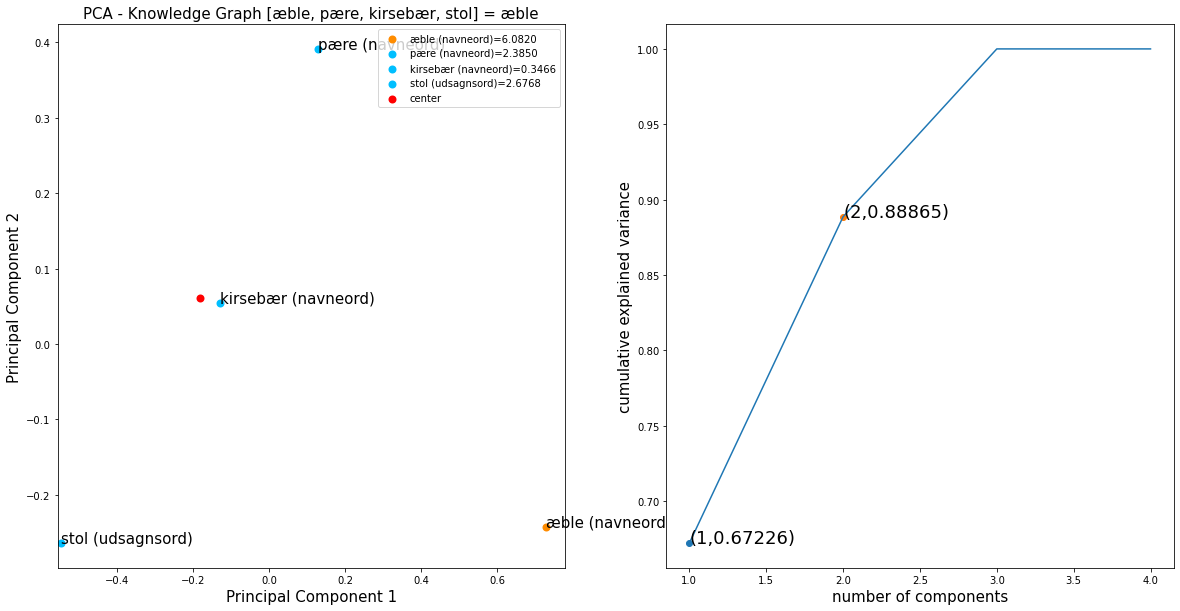

In [191]:
N = 0

Norm = 'NO'
method = 'PCA'     # SVD or PCA
plot = 'YES'       # YES or NO
W = Test_data  # Test_data or Wrong_words_4
PC = 2

#words, vecs, index_vec = words_vecs(N, Norm, sparql, W, N)
words, vecs, index_vec, Words_empty_gone, Forms, index_4_words = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap, propernouns)
mean_lexical, form, index, index_all_forms, form_ind = Average_lexical(words,vecs)


ITER, INDEX, pred = Average_four_words(N,method,plot,mean_lexical,W,form,index,index_vec,PC)


# Loop over entire dataset

In [194]:
import time

Class_correct = 0
Class_fail = 0
    
W = Test_data

for N in range(len(Test_data)):
    method = 'PCA'
    Norm = 'YES'
    plot = 'NO'
    PC = 3

    #words, vecs, index_vec = words_vecs(N, Norm, sparql, W, N)
    words, vecs, index_vec, Words_empty_gone, Forms, index_4_words = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap, propernouns)
    mean_lexical, form, index, index_all_forms, form_ind = Average_lexical(words,vecs)

    ITER, INDEX, pred = Average_four_words(N,method,plot,mean_lexical,W,form,index,index_vec,PC)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

    if (pred == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1

        
print('')
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

['æble', 'pære', 'kirsebær', 'stol'] = stol
['stol', 'bord', 'reol', 'græs'] = græs
['græs', 'træ', 'blomst', 'bil'] = græs
['bil', 'cykel', 'tog', 'vind'] = vind
['vind', 'regn', 'solskin', 'mandag'] = solskin
['mandag', 'tirsdag', 'søndag', 'tømrer'] = tømrer
['tømrer', 'vvs-mand', 'snedker', 'barn'] = barn
['barn', 'far', 'mormor', 'lampe'] = mormor
['lampe', 'stearinlys', 'lommelygte', 'jern'] = jern
['jern', 'guld', 'magnesium', 'sjov'] = sjov
['sjov', 'dårlig', 'vanvittig', 'papir'] = papir
['papir', 'ringbind', 'blyant', 'vagt'] = vagt
['vagt', 'politimand', 'fængselsbetjent', 'by'] = vagt
['by', 'landsby', 'købstad', 'småkage'] = småkage
['småkage', 'citronmåne', 'kringle', 'dør'] = dør
['dør', 'væg', 'vindue', 'klaver'] = væg
['klaver', 'trompet', 'blokfløjte', 'fandens'] = fandens
['fandens', 'fuck', 'sgu', 'vand'] = fuck
['vand', 'jord', 'ild', 'hukommelse'] = ild
['hukommelse', 'intelligens', 'emotion', 'Niels Bohr'] = Niels Bohr
['Niels Bohr', 'H.C. Ørsted', 'Ole Rømer', '

# PCA on 4 words

In [170]:
def PCA_4_words(W,plot,Norm, PC):
    vecs = []

    for i in range(len(W[N])):
        if Norm == 'YES':
            vecs.append(np.squeeze(preprocessing.normalize(np.expand_dims(model.wv[W[N][i]], axis=0), norm='l1')))
        if Norm == 'NO':
            vecs.append(model.wv[W[N][i]])

    mean_vec = np.mean(vecs,axis=0)
    
    vecs.append(mean_vec)
    print(len(vecs))

    PCA_var = PCA().fit(vecs)
    print(np.cumsum(PCA_var.explained_variance_ratio_))
    Comp = np.where(np.array(np.cumsum(PCA_var.explained_variance_ratio_)) >= 0.99999)[0][0]+1
    if Comp < 2:
        Comp = 2

    if PC == 'Comp':
        PC = Comp
    pca = PCA(n_components=PC, svd_solver = 'arpack')
    #X_pca = pca.fit_transform(vecs) # Calculate PCA of average vector
    X_pca = pca.fit_transform(StandardScaler().fit_transform(vecs))

    # Calculate distance from center point to all other points
    sum_var = 0
    for i in range(PC):
        sum_var += np.cumsum(PCA_var.explained_variance_ratio_)[i]

    # Calculate distance from center point to all other points
    Dist = np.zeros(len(X_pca)-1) 
    for i in range(len(X_pca)-1):
        for j in range(PC):
            if j == 0:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j])/sum_var)*100.0)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
            else:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j]-np.cumsum(PCA_var.explained_variance_ratio_)[j-1])/sum_var)*100.0)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
        Dist[i] = np.sqrt(Dist[i])
    

    pred = W[N][np.where(Dist == max(Dist))[0][0]]
    
    if plot == 'YES':
        for X_transformed, title in [(X_pca, "PCA")]:
            fig = plt.figure(figsize=(20, 8))
            plt.subplot(1,2,1)
            for i in range(len(X_pca)-1):
                plt.text(X_transformed[i,0], X_transformed[i,1], "%s" %(W[N][i]), color = 'black', size=18)
                plt.scatter(X_transformed[i,0], X_transformed[i,1], color='deepskyblue', lw=5, label="%s = %.3f" %(W[N][i],Dist[i]))

        plt.scatter(X_transformed[len(X_pca)-1, 0], X_transformed[len(X_pca)-1, 1],color='red', lw=2, label='center')   
        plt.title('PCA knowledge graph [%s, %s, %s, %s] = %s' %(W[N][0],W[N][1],W[N][2],W[N][3],pred), size=20)
        plt.xlim(min(X_transformed[:,0])-0.005,max(X_transformed[:,0])+0.012)
        plt.legend(prop={'size': 15},loc=4)
        
        plt.xlabel('Principal Component 1', size=15)
        plt.ylabel('Principal Component 2', size=15)

        plt.subplot(1,2,2)
        plt.plot(range(1,Comp+3),np.cumsum(PCA_var.explained_variance_ratio_)[:Comp+2])
        plt.scatter(1,np.cumsum(PCA_var.explained_variance_ratio_)[0])
        plt.text(1,np.cumsum(PCA_var.explained_variance_ratio_)[0], '(%d,%.5f)' %(1,np.cumsum(PCA_var.explained_variance_ratio_)[0]), size=18)
        if Comp > 1:
            plt.scatter(2,np.cumsum(PCA_var.explained_variance_ratio_)[1])
            plt.text(2,np.cumsum(PCA_var.explained_variance_ratio_)[1], '(%d,%.5f)' %(2,np.cumsum(PCA_var.explained_variance_ratio_)[1]), size=18)
        if Comp > 2:
            plt.scatter(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp])
            plt.text(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp], '(%d,%.2f)' %(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp]), size=18)
        plt.xlabel('number of components', size=15)
        plt.ylabel('cumulative explained variance', size=15);

        #plt.savefig('IMAGES/PCA_4_words.png')
    
    return pred

5
[0.4652093  0.77448038 1.         1.         1.        ]
['sjov', 'dårlig', 'vanvittig', 'papir'] = papir


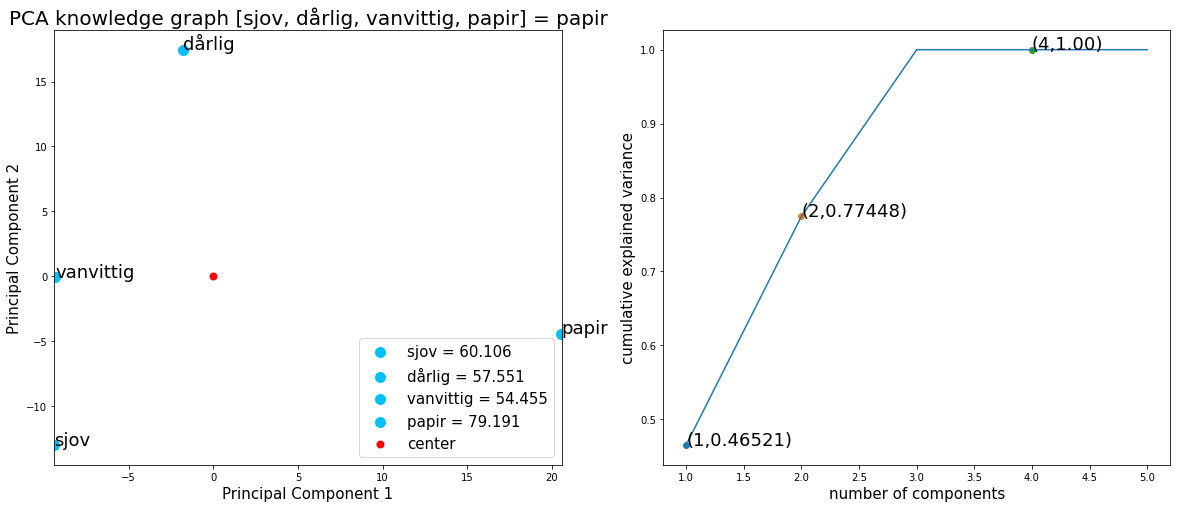

In [171]:
plot = 'YES'
Norm = 'YES'
N = 10
CP = 4

pred = PCA_4_words(W,plot,Norm,CP)
print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

In [111]:
Class_correct = 0
Class_fail = 0
Norm = 'YES'
plot = 'NO'
CP = 2

for N in range(len(Test_data)):
    
    pred = PCA_4_words(W,plot,Norm, CP)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

    if (pred == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1


print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

5
['æble', 'pære', 'kirsebær', 'stol'] = stol
5
['stol', 'bord', 'reol', 'græs'] = græs
5
['græs', 'træ', 'blomst', 'bil'] = bil
5
['bil', 'cykel', 'tog', 'vind'] = tog
5
['vind', 'regn', 'solskin', 'mandag'] = mandag
5
['mandag', 'tirsdag', 'søndag', 'tømrer'] = tømrer
5
['tømrer', 'vvs-mand', 'snedker', 'barn'] = barn
5
['barn', 'far', 'mormor', 'lampe'] = lampe
5
['lampe', 'stearinlys', 'lommelygte', 'jern'] = jern
5
['jern', 'guld', 'magnesium', 'sjov'] = sjov
5
['sjov', 'dårlig', 'vanvittig', 'papir'] = papir
5
['papir', 'ringbind', 'blyant', 'vagt'] = vagt
5
['vagt', 'politimand', 'fængselsbetjent', 'by'] = by
5
['by', 'landsby', 'købstad', 'småkage'] = småkage
5
['småkage', 'citronmåne', 'kringle', 'dør'] = dør
5
['dør', 'væg', 'vindue', 'klaver'] = klaver
5
['klaver', 'trompet', 'blokfløjte', 'fandens'] = fandens
5
['fandens', 'fuck', 'sgu', 'vand'] = vand
5
['vand', 'jord', 'ild', 'hukommelse'] = hukommelse
5
['hukommelse', 'intelligens', 'emotion', 'Niels Bohr'] = Niels Bohr


# PCA average 4 words

In [198]:
def PCA_avg_4_words(N,plot,Norm,PC):
    words, vecs, index_vec, Words_empty_gone, Forms, index_4_words = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap,propernouns)
    vecs_avg = []
    J = 0
    for i in range(4):
        vecs_lex = []
        for j in range(len(np.where(np.array(index_4_words) == i)[0])):
            vecs_lex.append(vecs[J])
            J += 1
        vecs_avg.append(np.mean(vecs_lex,axis=0))
    
    mean_vec = np.mean(vecs_avg,axis=0)
    vecs_avg.append(mean_vec)

    PCA_var = PCA().fit(vecs_avg)
    Comp = np.where(np.array(np.cumsum(PCA_var.explained_variance_ratio_)) >= 0.999999)[0][0]+1
    #print(np.cumsum(PCA_var.explained_variance_ratio_))

    if Comp < 2:
        Comp = 2

    if PC == 'Comp':
        PC = Comp
        
    pca = PCA(n_components=PC, svd_solver='arpack')
    X_pca = pca.fit_transform(vecs_avg)

    sum_var = 0
    for i in range(PC):
        sum_var += np.cumsum(PCA_var.explained_variance_ratio_)[i]

    # Calculate distance from center point to all other points
    Dist = np.zeros(len(X_pca)-1) 
    for i in range(len(X_pca)-1):
        for j in range(PC):
            if j == 0:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j])/sum_var)*100.0)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
            else:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j]-np.cumsum(PCA_var.explained_variance_ratio_)[j-1])/sum_var)*100.0)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
        Dist[i] = np.sqrt(Dist[i])
    
    
    pred = W[N][np.where(Dist == max(Dist))[0][0]]
    
    
    if plot == 'YES':
        for X_transformed, title in [(X_pca, "PCA")]:
            fig = plt.figure(figsize=(20, 8))
            plt.subplot(1,2,1)
            for i in range(len(X_pca)-1):
                plt.text(X_transformed[i,0], X_transformed[i,1], "%s" %(W[N][i]), color = 'black', size=18)
                plt.scatter(X_transformed[i,0], X_transformed[i,1], color='deepskyblue', lw=5, label="%s = %.3f" %(W[N][i],Dist[i]))

        plt.scatter(X_transformed[len(X_pca)-1, 0], X_transformed[len(X_pca)-1, 1],color='red', lw=2, label='center')   
        plt.title('PCA knowledge graph [%s, %s, %s, %s] = %s' %(W[N][0],W[N][1],W[N][2],W[N][3],pred), size=20)
        plt.xlim(min(X_transformed[:,0])-0.007,max(X_transformed[:,0])+0.01)
        plt.legend(prop={'size': 15},loc=2)
        
        plt.xlabel('Principal Component 1', size=15)
        plt.ylabel('Principal Component 2', size=15)

        plt.subplot(1,2,2)
        plt.plot(range(1,Comp+3),np.cumsum(PCA_var.explained_variance_ratio_)[:Comp+2])
        plt.scatter(1,np.cumsum(PCA_var.explained_variance_ratio_)[0])
        plt.text(1,np.cumsum(PCA_var.explained_variance_ratio_)[0], '(%d,%.5f)' %(1,np.cumsum(PCA_var.explained_variance_ratio_)[0]), size=18)
        if Comp > 1:
            plt.scatter(2,np.cumsum(PCA_var.explained_variance_ratio_)[1])
            plt.text(2,np.cumsum(PCA_var.explained_variance_ratio_)[1], '(%d,%.5f)' %(2,np.cumsum(PCA_var.explained_variance_ratio_)[1]), size=18)
        if Comp > 2:
            plt.scatter(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp])
            plt.text(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp], '(%d,%.2f)' %(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp]), size=18)
        plt.xlabel('number of components', size=15)
        plt.ylabel('cumulative explained variance', size=15);

        plt.savefig('IMAGES/PCA_avg_4_lexime.png')

    return pred

['bil', 'cykel', 'tog', 'vind'] = vind


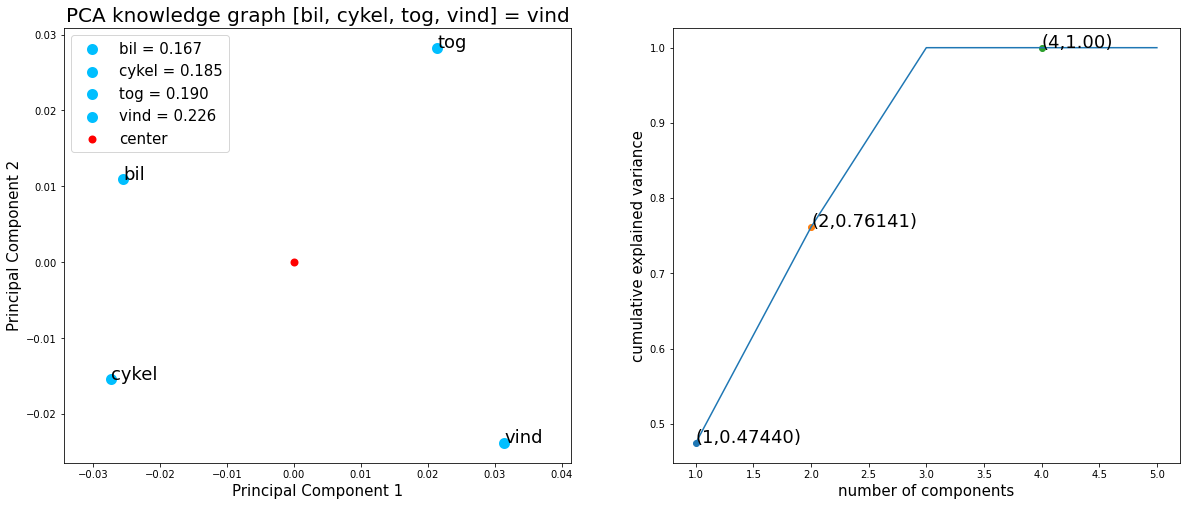

In [199]:
plot = 'YES'
Norm = 'YES'
N = 3
CP = 2

pred = PCA_avg_4_words(N,plot,Norm,CP)
print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

In [200]:
Class_correct = 0
Class_fail = 0
    
W = Test_data
method = 'PCA'
Norm = 'YES'
plot = 'NO'
PC = 2


index_fail = []

for N in range(len(Test_data)):    
    pred = PCA_avg_4_words(N,plot,Norm,PC)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

    if (pred == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1
        index_fail.append(N)

        
print('')
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

['æble', 'pære', 'kirsebær', 'stol'] = stol
['stol', 'bord', 'reol', 'græs'] = græs
['græs', 'træ', 'blomst', 'bil'] = bil
['bil', 'cykel', 'tog', 'vind'] = vind
['vind', 'regn', 'solskin', 'mandag'] = mandag
['mandag', 'tirsdag', 'søndag', 'tømrer'] = tømrer
['tømrer', 'vvs-mand', 'snedker', 'barn'] = barn
['barn', 'far', 'mormor', 'lampe'] = lampe
['lampe', 'stearinlys', 'lommelygte', 'jern'] = jern
['jern', 'guld', 'magnesium', 'sjov'] = sjov
['sjov', 'dårlig', 'vanvittig', 'papir'] = papir
['papir', 'ringbind', 'blyant', 'vagt'] = vagt
['vagt', 'politimand', 'fængselsbetjent', 'by'] = by
['by', 'landsby', 'købstad', 'småkage'] = småkage
['småkage', 'citronmåne', 'kringle', 'dør'] = dør
['dør', 'væg', 'vindue', 'klaver'] = klaver
['klaver', 'trompet', 'blokfløjte', 'fandens'] = fandens
['fandens', 'fuck', 'sgu', 'vand'] = vand
['vand', 'jord', 'ild', 'hukommelse'] = hukommelse
['hukommelse', 'intelligens', 'emotion', 'Niels Bohr'] = Niels Bohr
['Niels Bohr', 'H.C. Ørsted', 'Ole Røme

In [201]:
plot = 'NO'
for i in range(len(index_fail)):
    pred = PCA_avg_4_words(index_fail[i],plot,Norm,PC)
    print('%s = %s' %(W[index_fail[i]],pred))

['Niels Bohr', 'H.C. Ørsted', 'Ole Rømer', 'Lars Løkke Rasmussen'] = H.C. Ørsted
['Lars Løkke Rasmussen', 'Poul Nyrup Rasmussen', 'Anders Fogh Rasmussen', 'Peter Schmeichel'] = Anders Fogh Rasmussen
['ishockey', 'skiløb', 'skihop', 'fodbold'] = ishockey
['gå', 'løbe', 'kravle', 'sidde'] = kravle
['Kattegat', 'Øresund', 'Alssund', 'Sjælland'] = Alssund
['tv', 'radio', 'telefon', 'klud'] = tv
['gange', 'dividere', 'lægge sammen', 'vandrer'] = dividere
['mega', 'kæmpe', 'enorm', 'smule'] = mega
['tres', '60', 'LX', '3'] = tres
['1864', '1807', '1940', '1909'] = 1807
['dør', 'kradser af', 'udånder', 'åbner'] = udånder
['og', 'samt', 'endvidere', 'sin'] = og
['halvsyg', 'forkølelse', 'hoster', 'vej'] = halvsyg


# PCA all points (forms)

In [195]:
from matplotlib import pyplot as plt
def PCA_all_points(W,N,Norm,plot,NUM, wordToSimilarWordsMap, method,PC):
    words, vecs, index_vec, Words_empty_gone, Forms, index_4_word = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap, propernouns)
            
    # Calculate mean vector of all word-vectors. For the PCA plot
    vecs.append(np.mean(vecs,axis=0))


    if method == 'SVD':
            X_pca, s, Vh = np.linalg.svd(vecs,full_matrices=False)
    if method == 'PCA':
            PCA_var = PCA().fit(vecs)
            Comp = np.where(np.array(np.cumsum(PCA_var.explained_variance_ratio_)) >= 0.999)[0][0]
            if Comp < 2:
                Comp = 2
            #Comp = 3
            if PC == 'Comp':
                PC = Comp
            pca = PCA(n_components=PC, svd_solver = 'arpack')
            X_pca = pca.fit_transform(vecs) # Calculate PCA of average vector
            
    sum_var = 0
    for i in range(PC):
        sum_var += np.cumsum(PCA_var.explained_variance_ratio_)[i]

    # Calculate distance from center point to all other points
    Dist = np.zeros(len(X_pca)-1) 
    for i in range(len(X_pca)-1):
        for j in range(PC):
            if j == 0:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j])/sum_var)*100)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
            else:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j]-np.cumsum(PCA_var.explained_variance_ratio_)[j-1])/sum_var)*100)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
        Dist[i] = np.sqrt(Dist[i])
    
    Dist_sum = np.zeros(len(index_vec))

    # Sum distances in each lexical (plot if YES)
    if plot == 'NO':
        for i in range(len(X_pca)-1):
            #print('%s,      %s,    (%.2f,%.2f)' %(Words_empty_gone[i], Forms[i], X_transformed[i,0], X_transformed[i,1]))
            if (i >= 0) and (i < len(words[0])):
                Dist_sum[index_vec[0]] += Dist[i]

            if (i >= len(words[0])) and (i < len(words[0])+len(words[1])):
                Dist_sum[index_vec[1]] += Dist[i]

            if (i >= len(words[0])+len(words[1])) and (i < len(words[0])+len(words[1])+len(words[2])):
                Dist_sum[index_vec[2]] += Dist[i]

            if (i >= len(words[0])+len(words[1])+len(words[2])) and (i < len(words[0])+len(words[1])+len(words[2])+len(words[3])):
                Dist_sum[index_vec[3]] += Dist[i]

            if (i >= len(words[0])+len(words[1])+len(words[2])+len(words[3])) and (i < len(words[0])+len(words[1])+len(words[2])+len(words[3])+len(words[4])):
                Dist_sum[index_vec[4]] += Dist[i]
                
        for n in range(len(index_vec)):
            Dist_sum[n] /= len(words[n])
                
    elif plot == 'YES':
        for X_transformed, title in [(X_pca, "PCA")]:
            fig = plt.figure(figsize=(20, 8))
            plt.subplot(1,2,1)
            for i in range(len(X_pca)-1):
                #print('%s,      %s,    (%.2f,%.2f)' %(Words_empty_gone[i], Forms[i], X_transformed[i,0], X_transformed[i,1]))
                if (i >= 0) and (i < len(words[0])):
                    plt.text(X_transformed[i,0], X_transformed[i,1], "%s (%s)" %(Words_empty_gone[i],Forms[i]), color = 'black', size=10)
                    plt.scatter(X_transformed[i,0], X_transformed[i,1], color='deepskyblue', lw=5, label="%s (%s)" %(Words_empty_gone[i],Forms[i]))
                    Dist_sum[index_vec[0]] += Dist[i]

                if (i >= len(words[0])) and (i < len(words[0])+len(words[1])):
                    plt.text(X_transformed[i,0], X_transformed[i,1], "%s (%s)" %(Words_empty_gone[i],Forms[i]), color = 'black', size=10)
                    plt.scatter(X_transformed[i,0], X_transformed[i,1], color='orange', lw=5, label="%s (%s)" %(Words_empty_gone[i],Forms[i]))
                    Dist_sum[index_vec[1]] += Dist[i]

                if (i >= len(words[0])+len(words[1])) and (i < len(words[0])+len(words[1])+len(words[2])):
                    plt.text(X_transformed[i,0], X_transformed[i,1], "%s (%s)" %(Words_empty_gone[i],Forms[i]), color = 'black', size=10)
                    plt.scatter(X_transformed[i,0], X_transformed[i,1], color='lightgreen', lw=5, label="%s (%s)" %(Words_empty_gone[i],Forms[i]))
                    Dist_sum[index_vec[2]] += Dist[i]

                if (i >= len(words[0])+len(words[1])+len(words[2])) and (i < len(words[0])+len(words[1])+len(words[2])+len(words[3])):
                    plt.text(X_transformed[i,0], X_transformed[i,1], "%s (%s)" %(Words_empty_gone[i],Forms[i]), color = 'black', size=10)
                    plt.scatter(X_transformed[i,0], X_transformed[i,1], color='yellow', lw=5, label="%s (%s)" %(Words_empty_gone[i],Forms[i]))
                    Dist_sum[index_vec[3]] += Dist[i]

                if (i >= len(words[0])+len(words[1])+len(words[2])+len(words[3])) and (i < len(words[0])+len(words[1])+len(words[2])+len(words[3])+len(words[4])):
                    plt.text(X_transformed[i,0], X_transformed[i,1], "%s (%s)" %(Words_empty_gone[i],Forms[i]), color = 'black', size=10)
                    plt.scatter(X_transformed[i,0], X_transformed[i,1], color='pink', lw=5, label="%s (%s)" %(Words_empty_gone[i],Forms[i]))
                    Dist_sum[index_vec[4]] += Dist[i]

        # Divide the sum_distance with the number of words in the corresponding lexical
        for n in range(len(index_vec)):
            Dist_sum[n] /= len(words[n])

        plt.scatter(X_transformed[len(X_pca)-1, 0], X_transformed[len(X_pca)-1, 1],color='red', lw=2, label='center')
        plt.xlim(min(X_transformed[:,0])-0.2,max(X_transformed[:,0])+1.2)   
        plt.title('PCA knowledge graph [%s, %s, %s, %s] = %s' %(W[N][0],W[N][1],W[N][2],W[N][3], W[N][np.where(Dist_sum == max(Dist_sum))[0][0]]), size=20)

        plt.xlabel('Principal Component 1', size=15)
        plt.ylabel('Principal Component 2', size=15)
        plt.xlim(min(X_transformed[:,0])-0.007,max(X_transformed[:,0])+0.03)

        plt.subplot(1,2,2)
        plt.plot(range(1,Comp+3),np.cumsum(PCA_var.explained_variance_ratio_)[:Comp+2])
        plt.scatter(1,np.cumsum(PCA_var.explained_variance_ratio_)[0])
        plt.text(1,np.cumsum(PCA_var.explained_variance_ratio_)[0], '(%d,%.5f)' %(1,np.cumsum(PCA_var.explained_variance_ratio_)[0]), size=18)
        if Comp > 1:
            plt.scatter(2,np.cumsum(PCA_var.explained_variance_ratio_)[1])
            plt.text(2,np.cumsum(PCA_var.explained_variance_ratio_)[1], '(%d,%.5f)' %(2,np.cumsum(PCA_var.explained_variance_ratio_)[1]), size=18)
        if Comp > 2:
            plt.scatter(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp])
            plt.text(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp], '(%d,%.2f)' %(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp]), size=18)
        plt.xlabel('number of components', size=15)
        plt.ylabel('cumulative explained variance', size=15);

        #plt.savefig('IMAGES/PCA_all_points.png')

    # Prediction from the word with largest average sum of distance to the center point
    pred = W[N][np.where(Dist_sum == max(Dist_sum))[0][0]]

    return pred

In [165]:
Test_data[20:30]

[['Niels Bohr', 'H.C. Ørsted', 'Ole Rømer', 'Lars Løkke Rasmussen'],
 ['Lars Løkke Rasmussen',
  'Poul Nyrup Rasmussen',
  'Anders Fogh Rasmussen',
  'Peter Schmeichel'],
 ['Peter Schmeichel',
  'Kasper Schmeichel',
  'Brian Laudrup',
  'Caroline Wozniacki'],
 ['Caroline Wozniacki', 'Steffi Graf', 'Serena Williams', 'Monaco'],
 ['Monaco', 'Paris', 'Milano', 'Pia'],
 ['Pia', 'Lone', 'Marianne', 'Ole'],
 ['bold', 'fjerbold', 'puck', 'mave'],
 ['mave', 'bryst', 'ryg', 'hat'],
 ['hat', 'kasket', 'hue', 'ishockey'],
 ['ishockey', 'skiløb', 'skihop', 'fodbold']]

['Pia', 'Lone', 'Marianne', 'Ole'] = Ole

Number of correct classified: 1
Number of incorrect classified: 0

Accuracy: 100.00%


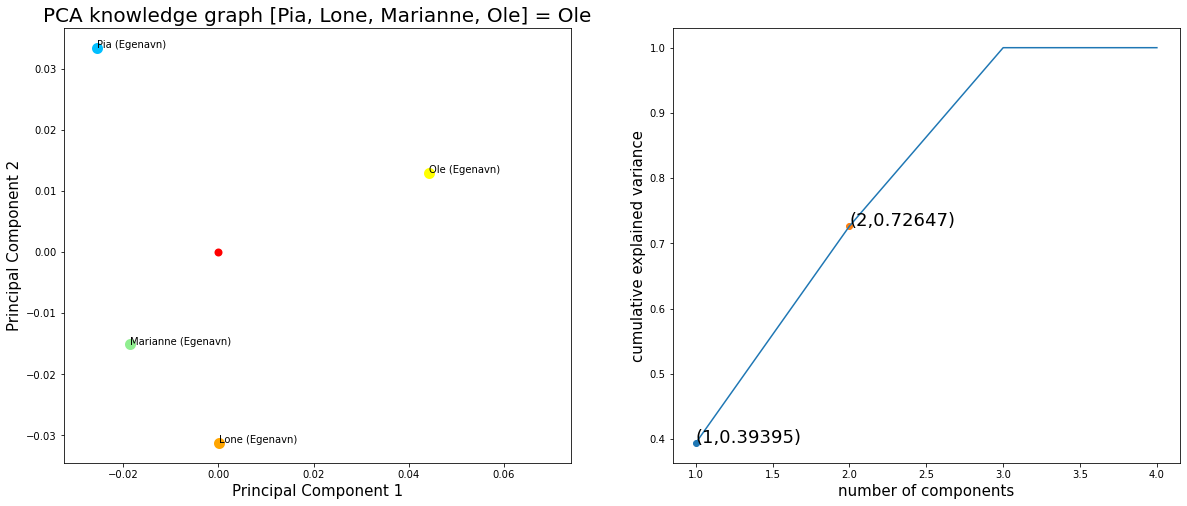

In [197]:
import time

N = 25

Class_correct = 0
Class_fail = 0
    
W = Test_data
Norm = 'YES'
plot = 'YES'
method = 'PCA'
PC = 2

for N in range(N,N+1):
    pred = PCA_all_points(W,N,Norm,plot,N, wordToSimilarWordsMap, method,PC)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

    if (pred == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1

print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

In [162]:
import time

N = 3

Class_correct = 0
Class_fail = 0
    
W = Test_data
Norm = 'YES'
plot = 'NO'
method = 'PCA'
PC = 4

for N in range(len(Test_data)):
    pred = PCA_all_points(W,N,Norm,plot,N, wordToSimilarWordsMap, method,PC)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

    if (pred == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1

print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

['æble', 'pære', 'kirsebær', 'stol'] = stol
['stol', 'bord', 'reol', 'græs'] = reol
['græs', 'træ', 'blomst', 'bil'] = bil
['bil', 'cykel', 'tog', 'vind'] = vind
['vind', 'regn', 'solskin', 'mandag'] = mandag
['mandag', 'tirsdag', 'søndag', 'tømrer'] = tømrer
['tømrer', 'vvs-mand', 'snedker', 'barn'] = barn
['barn', 'far', 'mormor', 'lampe'] = lampe
['lampe', 'stearinlys', 'lommelygte', 'jern'] = jern
['jern', 'guld', 'magnesium', 'sjov'] = jern
['sjov', 'dårlig', 'vanvittig', 'papir'] = papir
['papir', 'ringbind', 'blyant', 'vagt'] = vagt
['vagt', 'politimand', 'fængselsbetjent', 'by'] = by
['by', 'landsby', 'købstad', 'småkage'] = småkage
['småkage', 'citronmåne', 'kringle', 'dør'] = dør
['dør', 'væg', 'vindue', 'klaver'] = klaver
['klaver', 'trompet', 'blokfløjte', 'fandens'] = fandens
['fandens', 'fuck', 'sgu', 'vand'] = vand
['vand', 'jord', 'ild', 'hukommelse'] = hukommelse
['hukommelse', 'intelligens', 'emotion', 'Niels Bohr'] = Niels Bohr
['Niels Bohr', 'H.C. Ørsted', 'Ole Røme

In [163]:
plot = 'NO'
for i in range(len(index_fail)):
    pred = PCA_all_points(W,N,Norm,plot,N, wordToSimilarWordsMap, method,PC)
    print('%s = %s' %(W[index_fail[i]],pred))

['Niels Bohr', 'H.C. Ørsted', 'Ole Rømer', 'Lars Løkke Rasmussen'] = udsendelse
['Lars Løkke Rasmussen', 'Poul Nyrup Rasmussen', 'Anders Fogh Rasmussen', 'Peter Schmeichel'] = udsendelse
['ishockey', 'skiløb', 'skihop', 'fodbold'] = udsendelse
['gå', 'løbe', 'kravle', 'sidde'] = udsendelse
['Kattegat', 'Øresund', 'Alssund', 'Sjælland'] = udsendelse
['tv', 'radio', 'telefon', 'klud'] = udsendelse
['gange', 'dividere', 'lægge sammen', 'vandrer'] = udsendelse
['mega', 'kæmpe', 'enorm', 'smule'] = udsendelse
['tres', '60', 'LX', '3'] = udsendelse
['1864', '1807', '1940', '1909'] = udsendelse
['dør', 'kradser af', 'udånder', 'åbner'] = udsendelse
['og', 'samt', 'endvidere', 'sin'] = udsendelse
['halvsyg', 'forkølelse', 'hoster', 'vej'] = udsendelse


# PCA - Max lexeme of all words plot

In [81]:
def max_dist(W,N,Norm,plot,NUM, wordToSimilarWordsMap,PC):
    words, vecs, index_vec, Words_empty_gone, Forms, index_4_word = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap, propernouns)
            
    # Calculate mean vector of all word-vectors. For the PCA plot
    vecs.append(np.mean(vecs,axis=0))

    PCA_var = PCA().fit(vecs)
    Comp = np.where(np.array(np.cumsum(PCA_var.explained_variance_ratio_)) >= 0.999)[0][0]
    if Comp < 2:
        Comp = 2
        
    if PC == 'Comp':
        PC = Comp
        
    # Calculate PCA
    pca = PCA(n_components=PC, svd_solver = 'arpack')
    X_pca = pca.fit_transform(vecs) # Calculate PCA of average vector

    # Calculate distance from center point to all other points
    sum_var = 0
    for i in range(PC):
        sum_var += np.cumsum(PCA_var.explained_variance_ratio_)[i]

    # Calculate distance from center point to all other points
    Dist = np.zeros(len(X_pca)-1) 
    for i in range(len(X_pca)-1):
        for j in range(PC):
            if j == 0:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j])/sum_var)*100)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
            else:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j]-np.cumsum(PCA_var.explained_variance_ratio_)[j-1])/sum_var)*100)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
        Dist[i] = np.sqrt(Dist[i])
    # Prediction from the word with largest average sum of distance to the center point
    pred = W[N][index_4_word[np.where(Dist == max(Dist))[0][0]]]

    return pred

In [82]:
import time

N = 0

Class_correct = 0
Class_fail = 0
    
W = Test_data
Norm = 'YES'
plot = 'YES'
CP = 2

for N in range(N,N+1):
    pred = max_dist(W,N,Norm,plot,N, wordToSimilarWordsMap,CP)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

    if (pred == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1

print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

['æble', 'pære', 'kirsebær', 'stol'] = stol

Number of correct classified: 1
Number of incorrect classified: 0

Accuracy: 100.00%


In [87]:
import time

Class_correct = 0
Class_fail = 0
    
W = Test_data
Norm = 'YES'
plot = 'NO'
CP = 3

for N in range(len(Test_data)):
    pred = max_dist(W,N,Norm,plot,N, wordToSimilarWordsMap,CP)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

    if (pred == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1

print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

['æble', 'pære', 'kirsebær', 'stol'] = stol
['stol', 'bord', 'reol', 'græs'] = reol
['græs', 'træ', 'blomst', 'bil'] = bil
['bil', 'cykel', 'tog', 'vind'] = vind
['vind', 'regn', 'solskin', 'mandag'] = mandag
['mandag', 'tirsdag', 'søndag', 'tømrer'] = tømrer
['tømrer', 'vvs-mand', 'snedker', 'barn'] = barn
['barn', 'far', 'mormor', 'lampe'] = lampe
['lampe', 'stearinlys', 'lommelygte', 'jern'] = jern
['jern', 'guld', 'magnesium', 'sjov'] = magnesium
['sjov', 'dårlig', 'vanvittig', 'papir'] = papir
['papir', 'ringbind', 'blyant', 'vagt'] = vagt
['vagt', 'politimand', 'fængselsbetjent', 'by'] = by
['by', 'landsby', 'købstad', 'småkage'] = småkage
['småkage', 'citronmåne', 'kringle', 'dør'] = dør
['dør', 'væg', 'vindue', 'klaver'] = dør
['klaver', 'trompet', 'blokfløjte', 'fandens'] = fandens
['fandens', 'fuck', 'sgu', 'vand'] = vand
['vand', 'jord', 'ild', 'hukommelse'] = hukommelse
['hukommelse', 'intelligens', 'emotion', 'Niels Bohr'] = Niels Bohr
['Niels Bohr', 'H.C. Ørsted', 'Ole Rø

# PCA plot all words (but average each lexime)

In [88]:
import math
W = Test_data
N = 58
plot = 'YES'

words, vecs, index_vec, Words_empty_gone, Forms, j = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap,propernouns)

def PCA_average_lex(words,vecs,plot,PC):
    mean_lexical, form, index, index_all_forms, form_ind = Average_lexical(words,vecs)

    vecs_ave = []
    for i in range(len(mean_lexical)):
        vecs_ave.append(np.squeeze(mean_lexical[i]))

    AverageAverageVector = np.mean(vecs_ave,axis=0)
    vecs_ave.append(AverageAverageVector)

    PCA_var = PCA().fit(vecs_ave)

    if math.isnan(np.array(np.cumsum(PCA_var.explained_variance_ratio_)[0])) == True:
        Comp = 2
    else:
        Comp = np.where(np.array(np.cumsum(PCA_var.explained_variance_ratio_)) >= 0.99)[0][0]
        if Comp < 2:
            Comp = 2
            
    if PC == 'Comp':
        PC = Comp
    
    pca = PCA(n_components=PC, svd_solver = 'arpack')
    #X_pca = pca.fit_transform(vecs_ave) # Calculate PCA of average vector
    X_pca = pca.fit_transform(StandardScaler().fit_transform(vecs_ave))

    sum_var = 0
    for i in range(PC):
        sum_var += np.cumsum(PCA_var.explained_variance_ratio_)[i]

    # Calculate distance from center point to all other points
    Dist = np.zeros(len(X_pca)-1) 
    for i in range(len(X_pca)-1):
        for j in range(PC):
            if j == 0:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j])/sum_var)*100)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
            else:
                Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2 * (((np.cumsum(PCA_var.explained_variance_ratio_)[j]-np.cumsum(PCA_var.explained_variance_ratio_)[j-1])/sum_var)*100)
                #Dist[i] += (X_pca[-1,j]-X_pca[i,j])**2
        Dist[i] = np.sqrt(Dist[i])
        
    pred = W[N][index_vec[int(index[np.where(Dist == max(Dist))[0][0]])]]

    if plot == 'YES':
        for X_transformed, title in [(X_pca, "PCA")]:
            fig = plt.figure(figsize=(20, 10))
            plt.subplot(1,2,1)
            for i in range(len(X_pca)-1):
                plt.text(X_transformed[i,0], X_transformed[i,1], "%s (%s)" %(W[N][int(index[i])],form[i]), color = 'black', size=15)
                if Dist[i] == np.max(Dist):
                    plt.scatter(X_transformed[i,0], X_transformed[i,1], color='darkorange', lw=2, label="%s (%s)=%.4f" %(W[N][int(index[i])],form[i],Dist[i]))
                else:
                    plt.scatter(X_transformed[i,0], X_transformed[i,1], color='deepskyblue', lw=2, label="%s (%s)=%.4f" %(W[N][int(index[i])],form[i],Dist[i]))
           
        plt.scatter(X_transformed[len(X_pca)-1, 0], X_transformed[len(X_pca)-1, 1],color='red', lw=2, label='center')
        plt.title('PCA - KnowledgeGraph - [%s, %s, %s, %s] = %s' %(W[N][0],W[N][1],W[N][2],W[N][3], pred), size=15)
        plt.legend(loc="best", shadow=False, scatterpoints=1)   

        plt.xlabel('Principal Component 1', size=15)
        plt.ylabel('Principal Component 2', size=15)

        plt.xlim(min(X_transformed[:,0])-0.02,max(X_transformed[:,0])+1.5)

        plt.subplot(1,2,2)
        plt.plot(range(1,Comp+3),np.cumsum(PCA_var.explained_variance_ratio_)[:Comp+2])
        plt.scatter(1,np.cumsum(PCA_var.explained_variance_ratio_)[0])
        plt.text(1,np.cumsum(PCA_var.explained_variance_ratio_)[0], '(%d,%.5f)' %(1,np.cumsum(PCA_var.explained_variance_ratio_)[0]), size=18)
        if Comp > 1:
            plt.scatter(2,np.cumsum(PCA_var.explained_variance_ratio_)[1])
            plt.text(2,np.cumsum(PCA_var.explained_variance_ratio_)[1], '(%d,%.5f)' %(2,np.cumsum(PCA_var.explained_variance_ratio_)[1]), size=18)
        if Comp > 2:
            plt.scatter(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp])
            plt.text(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp], '(%d,%.2f)' %(Comp+1,np.cumsum(PCA_var.explained_variance_ratio_)[Comp]), size=18)
        plt.xlabel('number of components', size=15)
        plt.ylabel('cumulative explained variance', size=15);

        #plt.savefig('IMAGES/PCA_avg_4_words.png')
        
    return pred

['bil', 'cykel', 'tog', 'vind'] = bil


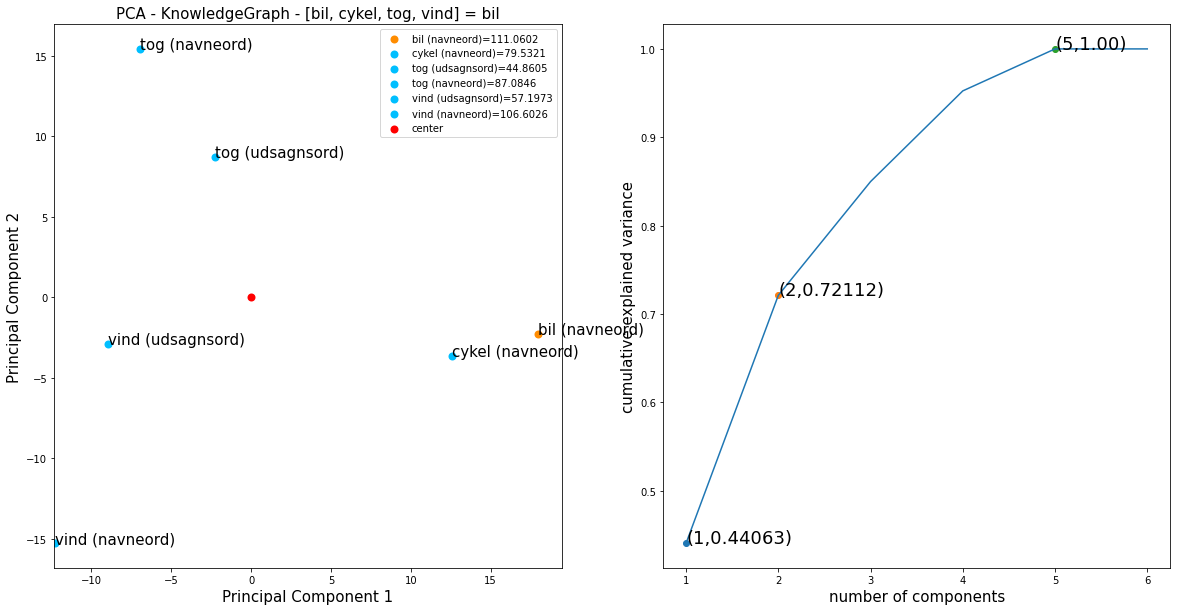

In [89]:
method = 'PCA'
Norm = 'YES'
plot = 'YES'

N = 3
CP = 2

words, vecs, index_vec, Words_empty_gone, Forms, index_4_words = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap,propernouns)
pred = PCA_average_lex(words,vecs,plot,CP)

print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

In [95]:
Class_correct = 0
Class_fail = 0
    
W = Test_data

for N in range(len(Test_data)):
    method = 'PCA'
    Norm = 'YES'
    plot = 'NO'
    CP = 'Comp'
    
    words, vecs, index_vec, Words_empty_gone, Forms, index_4_words = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap,propernouns)
    pred = PCA_average_lex(words,vecs,plot,CP)
    
    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

    if (pred == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1

        
print('')
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

['æble', 'pære', 'kirsebær', 'stol'] = stol
['stol', 'bord', 'reol', 'græs'] = græs
['græs', 'træ', 'blomst', 'bil'] = græs
['bil', 'cykel', 'tog', 'vind'] = bil
['vind', 'regn', 'solskin', 'mandag'] = solskin
['mandag', 'tirsdag', 'søndag', 'tømrer'] = tømrer
['tømrer', 'vvs-mand', 'snedker', 'barn'] = barn
['barn', 'far', 'mormor', 'lampe'] = mormor
['lampe', 'stearinlys', 'lommelygte', 'jern'] = lampe
['jern', 'guld', 'magnesium', 'sjov'] = magnesium
['sjov', 'dårlig', 'vanvittig', 'papir'] = papir
['papir', 'ringbind', 'blyant', 'vagt'] = vagt
['vagt', 'politimand', 'fængselsbetjent', 'by'] = vagt
['by', 'landsby', 'købstad', 'småkage'] = småkage
['småkage', 'citronmåne', 'kringle', 'dør'] = dør
['dør', 'væg', 'vindue', 'klaver'] = klaver
['klaver', 'trompet', 'blokfløjte', 'fandens'] = blokfløjte
['fandens', 'fuck', 'sgu', 'vand'] = fuck
['vand', 'jord', 'ild', 'hukommelse'] = ild
['hukommelse', 'intelligens', 'emotion', 'Niels Bohr'] = emotion
['Niels Bohr', 'H.C. Ørsted', 'Ole R

# 'Doesnt_match' manually implemented - Cosine
Normalized unit vector and cosine distance between the vectors to find outlier

In [ ]:
cosine_outliers = []
Class_correct = 0
Class_fail = 0
Norm = 'NO'

for N in range(len(Test_data)):

    vecs = []

    for i in range(len(W[N])):
        if Norm == 'YES':
            #vecs.append(model.wv.word_vec(Words_empty_gone[i], use_norm=True))
            #vecs.append(Normalize(model.wv[Words_empty_gone[i]]))
            vecs.append(np.squeeze(preprocessing.normalize(np.expand_dims(model.wv[W[N][i]], axis=0), norm='l1')))

        elif Norm == 'NO':
            #vecs.append(model.wv.word_vec(Words_empty_gone[i], use_norm=False)) 
            vecs.append(model.wv[W[N][i]])
            
    mean_vec = np.mean(vecs,axis=0)

    vectors = np.zeros((300,4))
    for i in range(4):
        for j in range(300):
            vectors[j][i] = vecs[i][j]

    #CO = np.dot(vectors.T,vectors)
    CO = np.dot(vectors,mean_vec)
    
    square_mag = np.diag(CO)
    inv_square_mag = 1 / square_mag
    inv_square_mag[np.isinf(inv_square_mag)] = 0
    inv_mag = np.sqrt(inv_square_mag)
    cosine = CO * inv_mag
    cosine = cosine.T * inv_mag
    indices = np.argsort(cosine.sum(axis=0))
    outlier = W[N][indices[0]]
    cosine_outliers.append(outlier)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', outlier)
    
    if (outlier == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1
      

print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

In [ ]:

cosine_outliers = []
Class_correct = 0
Class_fail = 0
Norm = 'YES'

for N in range(len(Test_data)):

    vecs = []

    for i in range(len(W[N])):
        if Norm == 'YES':
            #vecs.append(model.wv.word_vec(Words_empty_gone[i], use_norm=True))
            #vecs.append(Normalize(model.wv[Words_empty_gone[i]]))
            vecs.append(np.squeeze(preprocessing.normalize(np.expand_dims(model.wv[W[N][i]], axis=0), norm='l1')))

        elif Norm == 'NO':
            #vecs.append(model.wv.word_vec(Words_empty_gone[i], use_norm=False)) 
            vecs.append(model.wv[W[N][i]])
            
    
    mean_vec = np.mean(vecs,axis=0)

    Cosine_dist = np.zeros(4)
    for i in range(4):
        Cosine_dist[i] = distance.cosine(vecs[i], mean_vec)
    
    outlier = W[N][np.where(Cosine_dist == max(Cosine_dist))[0][0]]
    cosine_outliers.append(outlier)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', outlier)
    
    if (outlier == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1
      

print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

In [ ]:
import scipy

N = 1

def Cosine_avg_4_words(vecs, words, index_vec):
    mean_vec = np.mean(vecs,axis=0)

    Dist = np.zeros(len(vecs))

    for i in range(len(vecs)):
        Dist[i] = scipy.spatial.distance.cosine(mean_vec, vecs[i])
        #Dist[i] = np.dot(mean_vec, vecs[i])

    Dist_sum = np.zeros(len(index_vec))

    for i in range(len(vecs)):
        #print('%s,      %s,    (%.2f,%.2f)' %(Words_empty_gone[i], Forms[i], X_transformed[i,0], X_transformed[i,1]))
        if (i >= 0) and (i < len(words[0])):
            Dist_sum[index_vec[0]] += Dist[i]

        if (i >= len(words[0])) and (i < len(words[0])+len(words[1])):
            Dist_sum[index_vec[1]] += Dist[i]

        if (i >= len(words[0])+len(words[1])) and (i < len(words[0])+len(words[1])+len(words[2])):
            Dist_sum[index_vec[2]] += Dist[i]

        if (i >= len(words[0])+len(words[1])+len(words[2])) and (i < len(words[0])+len(words[1])+len(words[2])+len(words[3])):
            Dist_sum[index_vec[3]] += Dist[i]

        if (i >= len(words[0])+len(words[1])+len(words[2])+len(words[3])) and (i < len(words[0])+len(words[1])+len(words[2])+len(words[3])+len(words[4])):
            Dist_sum[index_vec[4]] += Dist[i]

    for n in range(len(index_vec)):
        Dist_sum[n] /= len(words[n])

    pred = W[N][np.where(Dist_sum == max(Dist_sum))[0][0]]
    return pred


In [ ]:
words[0]

In [ ]:
Class_correct = 0
Class_fail = 0
    
W = Test_data
Norm = 'YES'

for N in range(len(Test_data)):
    if mean_lexical != 0:
        words, vecs, index_vec, Words_empty_gone, Forms, index_4_words = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap, propernouns)
        mean_lexical, form, index, index_all_forms , form_ind = Average_lexical(words,vecs)

        pred = Cosine_avg_4_words(vecs, words, index_vec)
    
        print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', pred)

        if (pred == W[N][3]):
            Class_correct += 1
        else:
            Class_fail += 1
      
print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

# Same as for 'Doesnt_match' but using wikidata (all lexical)

In [ ]:
cosine_outliers = []
Class_correct = 0
Class_fail = 0

N = 2

for N in range(len(Test_data)):
    words, vecs, index_vec, Words_empty_gone, Forms, index_4_word = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap, propernouns)

    vectors = np.zeros((300,len(index_4_word)))

    for i in range(len(index_4_word)):
        for j in range(300):
            vectors[j][i] = vecs[i][j]

    CO = np.dot(vectors.T,vectors)
    square_mag = np.diag(CO)
    inv_square_mag = 1 / square_mag
    inv_square_mag[np.isinf(inv_square_mag)] = 0
    inv_mag = np.sqrt(inv_square_mag)
    cosine = CO * inv_mag
    cosine = cosine.T * inv_mag
    indices = np.argsort(cosine.sum(axis=0))
    outlier = W[N][index_vec[int(index_4_word[indices[0]])]]
    cosine_outliers.append(outlier)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', outlier)
    
    if (outlier == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1
      

print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

In [ ]:
corrcoef_outliers = []
Class_correct = 0
Class_fail = 0

N = 2

for N in range(len(Test_data)):
    words, vecs, index_vec, Words_empty_gone, Forms, index_4_word = words_vecs_json(N, Norm, W, N, wordToSimilarWordsMap, propernouns)

    vectors = np.zeros((300,len(index_4_word)))

    for i in range(len(index_4_word)):
        for j in range(300):
            vectors[j][i] = vecs[i][j]

    R = np.corrcoef(vectors.T)
    indices = np.argsort(R.sum(axis=0))
    outlier = W[N][index_vec[int(index_4_word[indices[0]])]]
    corrcoef_outliers.append(outlier)

    print([W[N][0],W[N][1],W[N][2],W[N][3]], '=', outlier)
    
    if (outlier == W[N][3]):
        Class_correct += 1
    else:
        Class_fail += 1
      

print()
print('Number of correct classified:', Class_correct)
print('Number of incorrect classified:', Class_fail)
print()
print('Accuracy: %.2f%%' %(Class_correct/(Class_correct+Class_fail)*100))

# Function to find optimal combination of three words and plot